[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/084_dlops_intro/084_dlops_intro.ipynb)

# DLOps - Introducci칩n

Con este post arrancamos una nueva serie en la que aprenderemos sobre DLOps. El t칠rmino DLOps es un derivado de [DevOps](https://es.wikipedia.org/wiki/DevOps#:~:text=DevOps%20(acr%C3%B3nimo%20ingl%C3%A9s%20de%20development,entrega%20continua%20de%20alta%20calidad.)), que a su vez hace referencia al conjunto de herramientas de software que nos ayudan al desarrollo y puesta en producci칩n de c칩digo asegurando su robustez y calidad durante todo el ciclo de vida. Si bien existen muchas herramientas y "buenas pr치cticas" para DevOps, su uso en aplicaciones de Inteligencia Artificial no siempre es directo. Esto es debido a las diferencias fundamentales entre el software tradicional (software 1.0) y el *machine learning* (software 2.0). As칤 pues, hablaremos sobre MLOps cuando nos refiramos a las herramientas que nos ayuden a desarrollar y poner en producci칩n algoritmos de *machine learning*, o DLOps en el caso del *deep learning*. Estas herramientas incluir치n, entre otras, la automatizaci칩n en el entrenamiento de modelos, versionado de datasets, puesta en producci칩n automatizada y monitoreo de modelos en producci칩n.

> Esta serie est치 basada en [este](https://github.com/graviraja/MLOps-Basics) stack. Sin embargo, usar칠 tecnolog칤as alternativas en ciertos puntos y tambi칠n los har칠 en otro orden que, en mi opini칩n, tiene m치s sentido y facilita las cosas. A칰n as칤, es un gran recurso para todos los interesados en aprender sobre DLOps.

## Objetivo

El objetivo de esta serie ser치 el de montar, desde cero, una infraestructura completa de *deep learning* con especial foco en la automatizaci칩n para que puedas aplicarlo a tus proyectos. Para ello, desarrollaremos un clasificador de im치genes de d칤gitos manuscritos usando el dataset MNIST. Este dataset es muy sencillo lo que nos permitir치 trabajar de manera r치pida. En una aplicaci칩n real, sin embargo, es posible que tengas que generar tu propio dataset recogiendo datos espec칤ficos de tu aplicaci칩n. El otro principal foco est치 puesto en la descentralizaci칩n, de manera que esta infraestructura pueda ser implementada en equipos con responsabilidades separadas: mientras que un equipo de cient칤ficos de datos trabaja en los datasets, recogiendo y etiquetando nuevas muestras, otro equipo de ingenieros podr치 trabajar en los modelos de manera separada y remota. Por otro lado, un equipo de QA minitorizar치 los modelos en producci칩n para alertar de cualquier anomal칤a.

## Nuestro primer dataset

En primer lugar, descargaremos el dataset MNIST. 

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000
)

len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

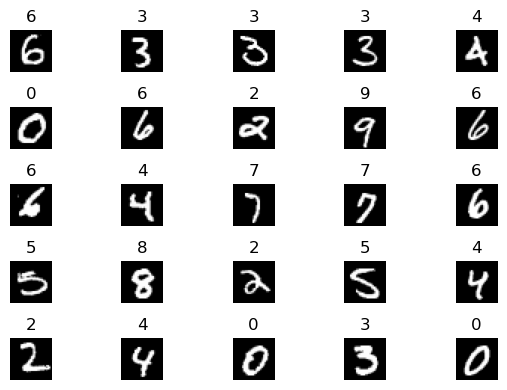

In [ ]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(dpi=100)
for ix in range(25):
	ax = plt.subplot(5, 5, ix + 1)
	i = random.randint(0, len(X_train)-1)
	img, label = X_train[i], y_train[i]
	ax.imshow(img.reshape(28,28), cmap='gray')
	ax.set_title(label)
	ax.axis('off')
plt.tight_layout()
plt.show()

En nuestra primera iteraci칩n, haremos un clasificador binario sencillo que detecte s칩lo el n칰mero 3. M치s adelante iremos complicando los requisitos, lo cual nos dar치 opci칩n a generar diferentes versiones de nuestro dataset y as칤 ver un ejemplo de las herramientas necesarias para ello. Adem치s, nos quedaremos con una peque침a muestra para empezar con un dataset limitado.

In [ ]:
import numpy as np

X_train_3 = X_train[y_train == '3'][:100]
X_train_no_3 = X_train[y_train != '3'][:100]

len(X_train_3), len(X_train_no_3)

(100, 100)

In [ ]:
def plot_samples(X):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(X)-1)
		img = X[i]
		ax.imshow(img.reshape(28,28), cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

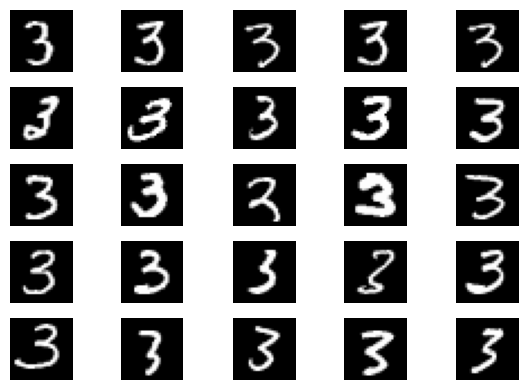

In [ ]:
plot_samples(X_train_3)

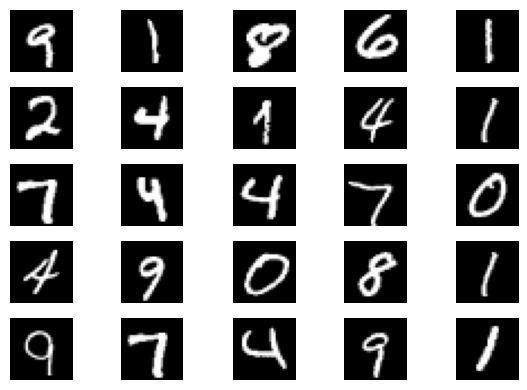

In [ ]:
plot_samples(X_train_no_3)

Ahora guardaremos las im치genes en sendas carpetas, separando adem치s un 20% de las muestras para el conjunto de test. A medida que nuestra aplicaci칩n vaya creciendo y siendo usada cada vez m치s deberemos identificar aquellos ejemplos en los que falla, etiquetarlo e incluirlos en el conjunto de test. Por otro lado, deberemos recoger ejemplos similares, etiquetarlos y a침adirlos al conjunto de entrenamiento. De este manera, al re-entrenar los modelos, nos aseguraremos de ir corrigiendo errores de manera adecuada (este proceso se conoce como *active learning*).

In [ ]:
import os 
from pathlib import Path
from skimage.io import imsave
import shutil

path = Path('dataset')

def generate_dataset(X_train_3, X_train_no_3, test_size):
	shutil.rmtree(path)
	os.makedirs(path, exist_ok=True)

	splits = ['train', 'test']
	for split in splits:
		os.makedirs(path / split, exist_ok=True)
		os.makedirs(path / split / '3', exist_ok=True)
		os.makedirs(path / split / 'no3', exist_ok=True)
		if split == 'train':
			X1, X2 = X_train_3[:-test_size], X_train_no_3[:-test_size]
		else:
			X1, X2 = X_train_3[-test_size:], X_train_no_3[-test_size:]
		for x1, x2 in zip(X1, X2):
			imsave(path / split / '3' / f'{random.randint(0, 99999):05d}.png', x1.reshape(28,28).astype('uint8'))
			imsave(path / split / 'no3' / f'{random.randint(0, 99999):05d}.png', x2.reshape(28,28).astype('uint8'))


In [ ]:
generate_dataset(X_train_3, X_train_no_3, 20)

In [ ]:
from glob import glob

def get_paths():
	train_3 = glob(str(path / 'train' / '3' / '*.png'))
	train_no3 = glob(str(path / 'train' / 'no3' / '*.png'))
	test_3 = glob(str(path / 'test' / '3' / '*.png'))
	test_no3 = glob(str(path / 'test' / 'no3' / '*.png'))
	return train_3, train_no3, test_3, test_no3

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(80, 80, 20, 20)

In [ ]:
from skimage.io import imread 

def plot_images(paths):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(paths)-1)
		img = imread(paths[i])
		ax.imshow(img, cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

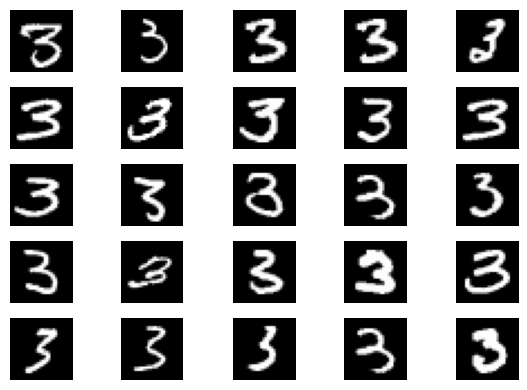

In [ ]:
plot_images(train_3)

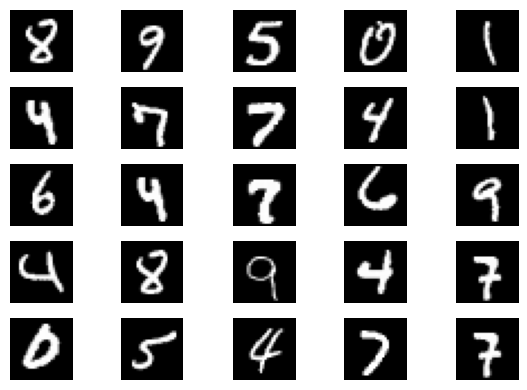

In [ ]:
plot_images(train_no3)

## Versionado de datos

En este punto hemos generado una primera versi칩n de nuestro dataset que queremos usar para entrenar nuestro primero modelo. Sabemos que en el futuro el dataset ir치 evolucionando, a침adiendo m치s ejemplos y clases (y en funci칩n de la aplicaci칩n potencialmente nuevas tareas). La opci칩n m치s sencilla para manejar esto ser칤a generar un `.zip` con nuestros datos, ponerle un nombre (por ejemplo, mnist-v1.0) y guardarlo en alg칰n servidor al cual puedan acceder los ingeniero de *deep learning* para entrenar modelos. Lo mismo podr칤amos hacer en el software 1.0 con nuestro c칩digo (y durante mucho tiempo as칤 se hizo, incluso quiz치s hay empresas que a칰n lo hacen 游땍) sin embargo hace tiempo que aprendimos que el uso de herramientas de `control de versi칩n` son mucho m치s 칰tiles y eficaces. El ejemplo principal es `git`. As칤 pues, para manejar nuestros datos (y m치s adelante modelos, m칠tricas e incluso `pipelines` de entrenamiento) usaremos una herramienta de `control de versi칩n` espec칤fica para trabajar con grandes datos en entornos de *machine learning* conocida como [dvc](https://dvc.org/). `dvc` trabaja en conjunto con `git`, as칤 que lo primero que necesitaremos ser치 un repositorio de `git`, que puedes alojar en `Github`, para manejar el proyecto.

> En mi caso he creado este [repo](https://github.com/juansensio/dlops) que usar칠 durante toda la serie de posts.

Puedes instalar `dvc` con el siguiente comando:

```
pip install dvc
```

Acto seguido, inicializaremos un repositorio con el comando: 

```
dvc init
```

Deber치s ejectuar el comando al mismo nivel que el de git, ya que `dvc` utiliza git para el control de version de los metadatos asociados a los datos (archivos grandes). Esto generar치 una carpeta `.dvc` y un archivo `.dvcignore` similar a git. Ahora podemos a침adir la carpeta con los datos al repositorio con el comando

```
dvc add dataset
```

El siguiente paso ser치 conectar `dvc` con un servicio de almacenamiento remoto en el que guardar nuestros datos. Puedes utilizar diferentes servicios, [aqu칤](https://dvc.org/features) tienes una lista. En este caso utilizaremos [firebase](https://firebase.google.com/), ya que m치s adelante usaremos otras caracter칤sticas como la base de datos. Para que `dvc` pueda acceder al `bucket` necesitaremos configurar la variable de entorno `GOOGLE_APPLICATION_CREDENTIALS`, siguiendo la [documentaci칩n](https://cloud.google.com/docs/authentication/getting-started#command-line) o descargando las credenciales desde la consola de firebase. Una vez conectado, podremos sincronizar nuestro dataset con el comando:

```
dvc push
```

Ahora puedes probar a eliminar la carpeta `dataset` y para volver a recuperarla puedes ejecutar

```
dvc pull dataset.dvc
```

Usaremos `git` para crear una nueva versi칩n con el comando

```
git tag -a v0 -m "version 0"
```

`git` guardar치 los archivos espec칤ficos de `dvc` del commit con el tag determinado.

```
git add .
git commit -m "primera versi칩n"
git push
git push origin --tags
```

En este punto, cualquiera con acceso al repositorio de `git` y `dvc` (con las credenciales necesarias de `firebase`) podr치 acceder al dataset y a todas sus versiones de manera sencilla y remota para usarlo para entrenar modelos o modificarlo y crear nuevas versiones.

```
dvc pull
```

## Creando nuevas versiones

Ahora vamos a generar una nueva versi칩n del dataset con 100 muestras m치s de las que ten칤amos anteriormente.

In [ ]:
X_train_3 = X_train[y_train == '3'][:200]
X_train_no_3 = X_train[y_train != '3'][:200]

len(X_train_3), len(X_train_no_3)

(200, 200)

In [ ]:
generate_dataset(X_train_3, X_train_no_3, 40)

In [ ]:
train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(160, 160, 40, 40)

Utilizaremos los comando vistos anteriormente para crear una nueva versi칩n:

```
dvc add dataset
dvc push 
git add .
git commit -m 'nueva version'
git push
git tag -a v1 -m "version 1"
git push origin --tags
```

Ahora que tenemos diferentes versiones podemos ir cambiando entre ellas de la siguiente manera.

```
git checkout tags/v0
dvc pull
```

In [ ]:
# versi칩n 0 con 80/20 split

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(80, 80, 20, 20)

```
git checkout tags/v1
dvc pull
```

In [ ]:
# versi칩n 1 con 160/40 split

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(160, 160, 40, 40)

## Resumen

En este post hemos aprendido a usar la herramienta de control de versiones [`dvc`](https://dvc.org/), la cual hemos usado para versionar nuestro dataset pero que tambi칠n usaremos m치s adelante para versionar modelos, m칠tricas e incluso `pipelines` completas de entrenamiento muy 칰tiles para automatizaci칩n. En este ejemplo hemos visto como generar varias versiones de un dataset para clasificaci칩n binaria de d칤gitos manuscritos que usaremos de ahora en adelante a medida que vayamos introduciendo t칠cnicas y herramientas de DLOps y el cual iremos modificando (y versionando), a침adiendo m치s ejemplos y m치s clases.